   # PTEN: Effects of Mutation on Interacting Proteins

<b>Standard imports for playing with and plotting data frames.</b>

In [39]:
import pandas as pd
import numpy as np
import re
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns

<b>Import CPTAC data</b>

In [40]:
import CPTAC

In [41]:
somatic_mutations = CPTAC.get_somatic()
proteomics = CPTAC.get_proteomics()
phos = CPTAC.get_phosphoproteomics()

print(proteomics)

idx     A1BG     A2M    A2ML1  A4GALT      AAAS    AACS    AADAT    AAED1  \
S001 -1.1800 -0.8630 -0.80200  0.2220  0.256000  0.6650  1.28000 -0.33900   
S002 -0.6850 -1.0700 -0.68400  0.9840  0.135000  0.3340  1.30000  0.13900   
S003 -0.5280 -1.3200  0.43500     NaN -0.240000  1.0400 -0.02130 -0.04790   
S004  2.3500  2.8200 -1.47000     NaN  0.154000  0.0332  0.51300  0.67400   
S005 -1.6700 -1.1900 -0.44300  0.2430 -0.099300  0.7570  0.74000 -0.92900   
S006 -0.3740 -0.0206 -0.53700  0.3110  0.375000  0.0131 -1.10000      NaN   
S007 -1.0800 -0.7080 -0.12600 -0.4260 -0.114000 -0.1110  0.89500  1.26000   
S008 -1.3200 -0.7080 -0.80800 -0.0709  0.138000  0.6560 -0.28000 -0.12800   
S009 -0.4670  0.3700 -0.33900     NaN  0.434000  0.0358 -0.17500  0.18100   
S010 -1.1200 -1.3100  0.91200  0.4180 -0.076800  0.8460 -0.12100      NaN   
S011 -0.7160 -0.8850  2.82000 -0.3430  0.147000  0.4450 -0.05650 -0.83800   
S012 -0.2320 -0.0910  0.61800  1.6300 -0.250000  1.3300 -1.72000 -0.88900   

### List of proteins that interact with PTEN (according to Uniprot and String)

In [42]:
gene = 'PTEN'
protList = ['AKT1', 'PIK3R2', 'PIK3R1', 'PIK3CB', 'PIK3CA', 'PTK2', 'USP7', 'TP53', 'PDGFRB', 'MAGI2', 'MAGI3', 'MAST1', 'MAST3', 'NDFIP1', 'NDFIP2',
           'FRK', 'ROCK1', 'STK11']

## t-test for effects of missense mutations

In [43]:
tested = [];
p_vals = [];

cutoff = 0.05/len(protList)
for protein in protList: 
    if protein in proteomics.columns:
        tested.append(protein)
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross.loc[cross['Patient_Type'] == 'Tumor'][["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] == "Missense_Mutation"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if ttest[1] < cutoff:
            p_vals.append(ttest[1])
            print(site, " ", ttest[1])

## t-test for effects of frame shift and nonsense mutations (truncating)

In [44]:
tested = [];
p_vals = [];
for protein in protList: 
    if protein in proteomics.columns:
        tested.append(protein)
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross.loc[cross['Patient_Type'] == 'Tumor'][["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[(cross["Mutation"] == "Frame_Shift_Del") | 
                            (cross["Mutation"] == "Frame_Shift_Ins") |
                            (cross["Mutation"] == 'Nonsense_Mutation')]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        p_vals.append(ttest[1])

## t-test for effects of missense and truncating mutations combined

In [45]:
tested = [];
p_vals = [];
for protein in protList: 
    if protein in proteomics.columns:
        tested.append(protein)
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross.loc[cross['Patient_Type'] == 'Tumor'][["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[(cross["Mutation"] == "Frame_Shift_Del") | 
                            (cross["Mutation"] == "Frame_Shift_Ins") |
                            (cross["Mutation"] == 'Nonsense_Mutation') |
                            (cross["Mutation"] == 'Missense_Mutation')]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if ttest[1] < cutoff:
            p_vals.append(ttest[1])
            print(protein, " ", ttest)

PIK3CA   Ttest_indResult(statistic=-4.221717816045985, pvalue=5.466584409144104e-05)
TP53   Ttest_indResult(statistic=-3.9533495380869828, pvalue=0.00015886590461962268)


## t-test for effects of all mutations

In [46]:
tested = [];
p_vals = [];

significantResults = []
for protein in protList: 
    if protein in proteomics.columns:
        tested.append(protein)
        cross = CPTAC.compare_mutations(proteomics, protein, gene)
        cross = cross.loc[cross['Patient_Type'] == 'Tumor'][["Mutation", protein]].dropna(axis=0)
        mutated = cross.loc[cross["Mutation"] != "Wildtype"]
        wt = cross.loc[cross["Mutation"] == "Wildtype"]
        #print("Wildtype ", len(wt))
        #print("Mutated ", len(mutated))
        ttest = scipy.stats.ttest_ind(mutated[protein], wt[protein])
        if ttest[1] < cutoff:
            p_vals.append(ttest[1])
            significantResults.append(protein)
            print(protein, " ", ttest)

PIK3CA   Ttest_indResult(statistic=-4.214686821419194, pvalue=5.5710059173315194e-05)
TP53   Ttest_indResult(statistic=-4.002755994610535, pvalue=0.00013232110188039883)


### Build the dataframe for plotting

In [47]:
plotdf = None
for protein in significantResults:
    tempdf = CPTAC.compare_mutations(proteomics, protein, gene)
    tempdf = tempdf.loc[tempdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis=1)
    tempdf.loc[(tempdf['Mutation'] == "Wildtype"), "Mutation"] = "Control"
    tempdf.loc[(tempdf['Mutation'] != "Control"), "Mutation"] = "Mutated"
    tempdf = pd.melt(tempdf, id_vars=['Mutation'], var_name='Type', value_name='Reading')
    tempdf = tempdf.loc[(tempdf["Mutation"] == "Control") | (tempdf["Mutation"] == "Mutated")]
    tempdf = tempdf.dropna(axis=0).sort_values(by=['Mutation'], ascending=False)
    #print(tempdf)
    if plotdf is None:
        plotdf = tempdf
    else:
        plotdf = plotdf.append(tempdf)

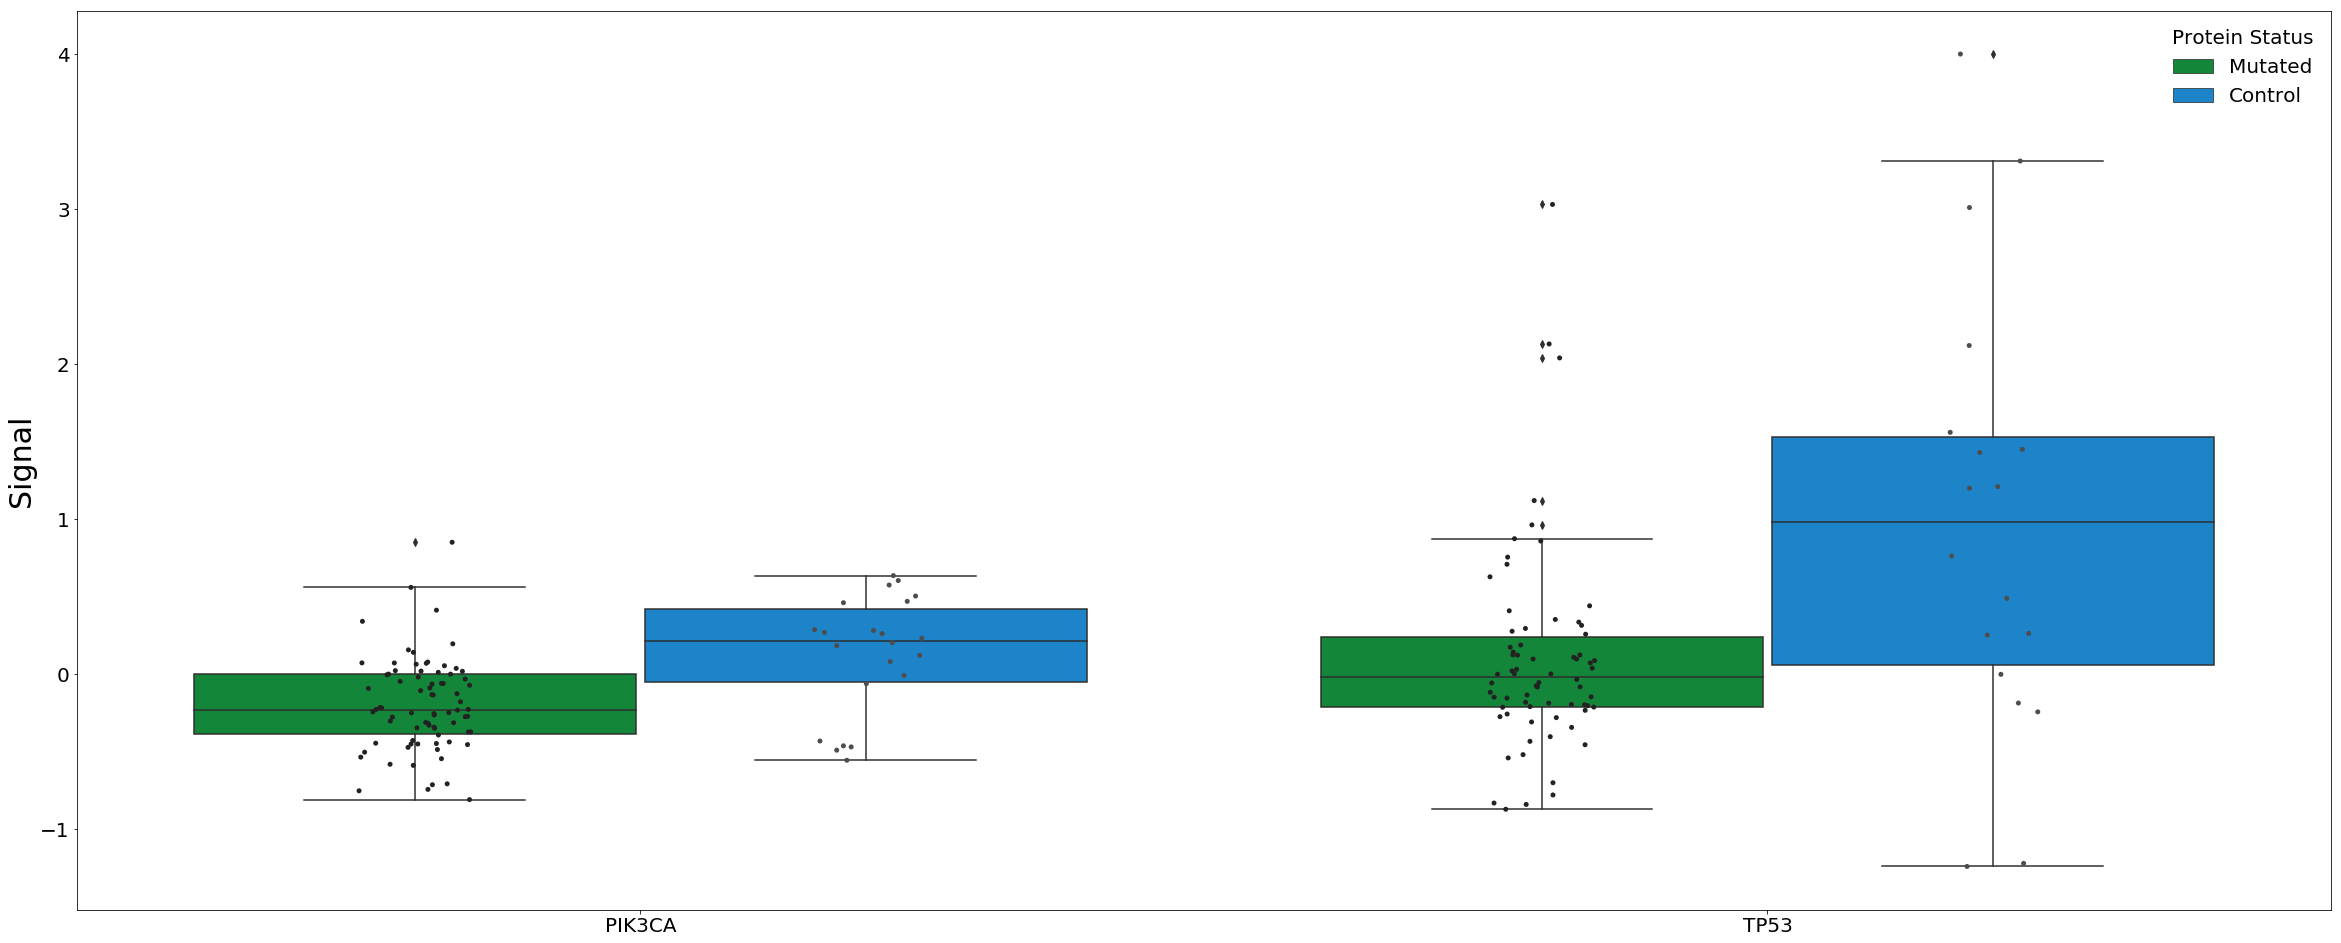

In [48]:
a4_dims = (40.4, 16.54)
fig, ax = plt.subplots(figsize=a4_dims)
my_pal = {"Mutated": "#009933", "Control": "#008ae6"}

#Create the plot
boxplt = sns.boxplot(x= 'Type', y= 'Reading', hue='Mutation', data=plotdf, palette=my_pal)
boxplt = sns.stripplot(data=plotdf, x='Type', y='Reading', hue='Mutation', dodge=True, jitter=True, color='.3')

#Add styling
boxplt.set_xlabel('')
boxplt.set_ylabel('Signal', fontsize='30')
boxplt.tick_params(labelsize='20')

#Adjust legend
handles, labels = ax.get_legend_handles_labels()
plt.legend(handles[0:2], ['Mutated', 'Control'], title='Protein Status', fontsize='20', frameon=False)
boxplt.get_legend().get_title().set_fontsize('20')
#boxplt.get_legend().set_bbox_to_anchor((1, 1, 0, 0))


fig = boxplt.get_figure()
plt.show()

In [49]:
site = 'PIK3CA'
phosdf = CPTAC.compare_mutations(proteomics, site, 'PTEN')
phosdf = phosdf.loc[phosdf['Patient_Type'] == 'Tumor']

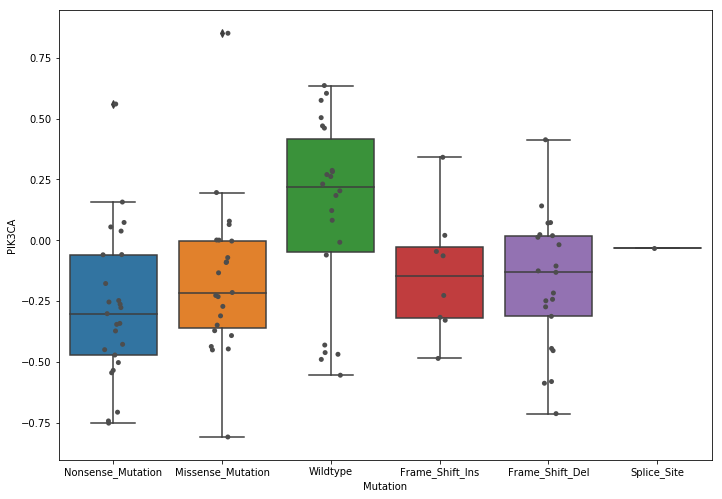

In [50]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

boxplt = sns.boxplot(data = phosdf, x = 'Mutation', y = site)
boxplt = sns.stripplot(data = phosdf, x = 'Mutation', y = site, jitter = True, color = '.3')
plt.show()

## Phosphoproteome abundance of interacting proteins

### This is the same list as before, with some of the end numbers of the proteins removed; less specificity in protein names captures more potentially significant results in the phosphoproteomic data

In [51]:
gene = 'PTEN'
phosProtList = protList

In [52]:

p_values = []
site_names = []


#Get the total number of sites that will be tested
total_sites = 0

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        for site in phosphositesdf.columns:
            total_sites +=1

cutoff = 0.05/total_sites

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, phosProtList)
    if next(isInList, None) is not None:
        phosdf = CPTAC.compare_mutations(phos, protein, gene)
        for site in phosdf.columns:
            if(site != gene and site != 'idx'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                sitedf = sitedf.loc[sitedf['Patient_Type'] == 'Tumor'].dropna(axis=0)
                mutated_site = sitedf.loc[sitedf['Mutation'] != 'Wildtype']
                wt_site = sitedf.loc[sitedf['Mutation'] == 'Wildtype']
                if len(mutated_site) > 2:
                    ttest = scipy.stats.ttest_ind(mutated_site[site], wt_site[site])
                    if ttest[1] <= pcutoff:
                        print(site)
                        print(ttest)                

NameError: name 'sites' is not defined

## Plot phosphorylation at one site

In [ ]:
sitedf = CPTAC.compare_mutations(phos, site, gene)
sitedf = sitedf.loc[sitedf['Patient_Type'] == 'Tumor'].dropna(axis=0)
mutated_site = sitedf.loc[sitedf['Mutation'] != 'Wildtype']
wt_site = sitedf.loc[sitedf['Mutation'] == 'Wildtype']
ttest = scipy.stats.ttest_ind(mutated_site[site], wt_site[site])
print(ttest)

a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize = a4_dims)
boxplt = sns.boxplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, ax = ax)
boxplt = sns.stripplot(data = p53_mutations_protein, x = 'Within_Hotspot', y = protein, jitter = True, color = '.3')
boxplt.set_xlabel('Mutation Within Hotspot', fontsize='20')
boxplt.set_ylabel('Protein Level', fontsize='20')
boxplt.set_title("Effect of TP53 mutation on " + protein + " protein levels", fontsize='22')
plt.show()

### Look at truncating mutations

In [56]:
sites = phos.columns
p_values = []
site_names = []


#Get the total number of sites that will be tested
total_sites = 0

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        for site in phosphositesdf.columns:
            total_sites +=1

cutoff = 0.05/total_sites

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        #cutoff = 0.05/(len(phosphositesdf.columns) - 2)
        for site in phosphositesdf.columns:
            if (site is not 'Mutation'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                mutateddf = sitedf.loc[(sitedf["Mutation"] == "Frame_Shift_Del") | 
                            (sitedf["Mutation"] == "Frame_Shift_Ins") |
                            (sitedf["Mutation"] == 'Nonsense_Mutation')].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                if ttest[1] < cutoff:
                    p_values.append(ttest[1])
                    site_names.append(site)     
                    print(site, " ", ttest)
                


AKT1-S124   Ttest_indResult(statistic=-4.197264306340348, pvalue=5.235627991954265e-05)
AKT1-S126   Ttest_indResult(statistic=-4.606476806500214, pvalue=9.81847044727198e-06)
AKT1-S129   Ttest_indResult(statistic=-5.079697894290569, pvalue=1.316039812638559e-06)
PIK3CA-S312   Ttest_indResult(statistic=-5.215950581308962, pvalue=1.6862189170882383e-06)
PTK2-S807   Ttest_indResult(statistic=-4.606770600219903, pvalue=1.1851786384314402e-05)
PTK2-Y661   Ttest_indResult(statistic=-7.09958629472072, pvalue=1.216485461905824e-10)
PTK2-Y662   Ttest_indResult(statistic=-6.509890406395231, pvalue=4.817642262998727e-09)
TP53BP1-S1033   Ttest_indResult(statistic=4.432511197930399, pvalue=1.9918643841864058e-05)
TP53BP1-S1072   Ttest_indResult(statistic=4.67558686997261, pvalue=7.857214776273573e-06)
TP53BP1-S1099   Ttest_indResult(statistic=4.9688386484667735, pvalue=2.1301654693930482e-06)
TP53BP1-S338   Ttest_indResult(statistic=4.434849611785817, pvalue=2.0542672537393225e-05)
TP53BP1-S512   T

## Missense and truncating

In [58]:
sites = phos.columns
p_values = []
site_names = []

#Get the total number of sites that will be tested
total_sites = 0

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        for site in phosphositesdf.columns:
            total_sites +=1

cutoff = 0.05/total_sites


for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        for site in phosphositesdf.columns:
            if (site is not 'Mutation'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                mutateddf = sitedf.loc[(sitedf["Mutation"] == "Frame_Shift_Del") | 
                        (sitedf["Mutation"] == "Frame_Shift_Ins") |
                        (sitedf["Mutation"] == 'Nonsense_Mutation') |
                        (sitedf["Mutation"] == 'Missense_Mutation')            ].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                if ttest[1] < cutoff:
                    p_values.append(ttest[1])
                    site_names.append(site)  
                    print(site, " ", ttest[1])


AKT1-S124   5.782239980115453e-06
AKT1-S126   5.988885536569973e-07
AKT1-S129   3.4571790280847676e-08
PIK3R1-S154   4.324911905663183e-05
PIK3CA-S312   1.882471025156517e-07
PTK2-S807   7.60908358639563e-06
PTK2-Y661   3.477400028601845e-13
PTK2-Y662   1.6547585223126498e-10
TP53BP1-S1004   2.6393196651591007e-05
TP53BP1-S1033   2.5209606781200713e-05
TP53BP1-S1072   7.331925442355188e-06
TP53BP1-S1099   5.207652243319692e-07
TP53BP1-S338   1.998875305942792e-06
TP53BP1-S512   8.580846126435513e-11
TP53BP1-S525   3.7429449576433537e-07
TP53BP1-S665   1.133278013074344e-10
TP53BP1-S667   3.781301460054111e-11
TP53BP1-S679   4.349534252122473e-06
TP53BP1-S789   1.19303798103777e-06
TP53BP1-S791   7.538388544617765e-05
TP53BP1-S814   1.7042600102456528e-05
TP53BP1-T1643   7.384863429345417e-08
TP53BP1-T1645   1.3886513001648708e-05
TP53BP1-T1653   4.378423799809717e-06
TP53BP1-T339   3.0788271393553404e-07
TP53BP1-T548   1.4744525684569943e-06
TP53BP1-T591   3.1940320448182394e-06
TP53BP

### Look at all mutations

In [82]:
sites = phos.columns
p_values = []
site_names = []

total_sites = 0

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        for site in phosphositesdf.columns:
            total_sites +=1

cutoff = 0.05/total_sites


for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        for site in phosphositesdf.columns:
            if (site is not 'Mutation' and site is not 'Patient_Type'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                mutateddf = sitedf.loc[sitedf["Mutation"] != 'Wildtype'].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                if ttest[1] < cutoff:
                    p_values.append(ttest[1])
                    site_names.append(site)
                    print(site, " ", ttest[1])



AKT1-S124   4.3878452856271334e-06
AKT1-S126   6.502007928544618e-07
AKT1-S129   3.0628964158401015e-08
AKT1S1-S108   0.00010497800313945146
PIK3R1-S154   2.5024667633889924e-05
PIK3CA-S312   1.882471025156517e-07
PIK3CA-T313   8.432875990279619e-05
PTK2-S807   7.110204063419284e-06
PTK2-Y661   2.324697103436591e-13
PTK2-Y662   1.392372230028616e-10
TP53BP1-S1004   2.011491512653496e-05
TP53BP1-S1033   1.924601976170492e-05
TP53BP1-S1072   7.499459353101512e-06
TP53BP1-S1099   3.161179320719698e-07
TP53BP1-S1683   9.816206781435526e-05
TP53BP1-S338   1.2561334134065202e-06
TP53BP1-S512   4.560452985918951e-11
TP53BP1-S525   2.9168699535079006e-07
TP53BP1-S665   7.008689378252958e-11
TP53BP1-S667   2.1818067857860122e-11
TP53BP1-S679   1.1371805012348104e-06
TP53BP1-S789   2.7041027801347735e-06
TP53BP1-S814   1.646837440523267e-05
TP53BP1-T1643   4.288600352142869e-08
TP53BP1-T1645   9.099401406817962e-06
TP53BP1-T1653   2.7196864328969176e-06
TP53BP1-T339   1.974271319966684e-07
TP53B

In [85]:
phosProtList = ['AKT1']

for protein in phosProtList:
    pattern = re.compile(protein)
    isInList = filter(pattern.search, sites)
    if next(isInList, None) is not None:
        phosphositesdf = CPTAC.compare_mutations(phos, protein, gene)
        phosphositesdf = phosphositesdf.loc[phosphositesdf['Patient_Type'] == 'Tumor'].drop('Patient_Type', axis = 1)
        for site in phosphositesdf.columns:
            if (site is not 'Mutation' and site is not 'Patient_Type'):
                sitedf = CPTAC.compare_mutations(phos, site, gene)
                mutateddf = sitedf.loc[sitedf["Mutation"] != 'Wildtype'].dropna(axis=0)
                wtdf = sitedf.loc[sitedf['Mutation'] == 'Wildtype'].dropna(axis=0)
                ttest = scipy.stats.ttest_ind(mutateddf[site], wtdf[site])
                if ttest[1] < cutoff:
                    p_values.append(ttest[1])
                    site_names.append(site)
                    print(site, " ", ttest[1])

AKT1-S124   4.3878452856271334e-06
AKT1-S126   6.502007928544618e-07
AKT1-S129   3.0628964158401015e-08
AKT1S1-S108   0.00010497800313945146


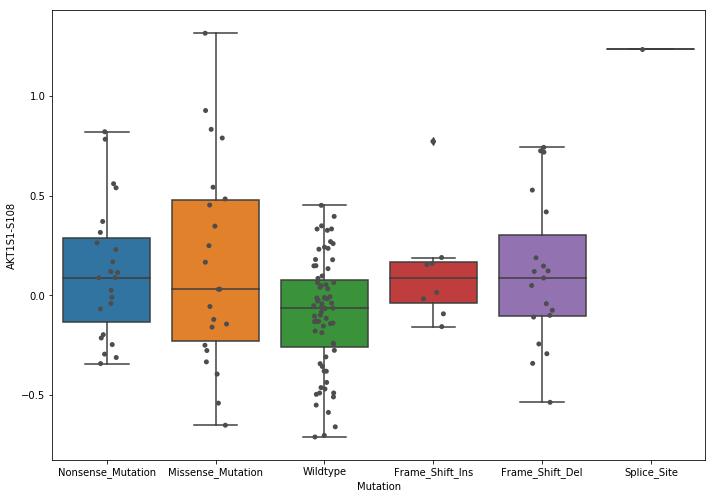

In [92]:
a4_dims = (11.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)

site = 'AKT1S1-S108'
sitedf = CPTAC.compare_mutations(phos, site, gene)

boxplt = sns.boxplot(data = sitedf, x = 'Mutation', y = site)
boxplt = sns.stripplot(data = sitedf, x = 'Mutation', y = site, jitter = True, color = '.3')
plt.show()